### Import Packages

In [1]:
from collections import defaultdict
import json
import multiprocessing as mp
import os
import random
import sys

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pprint import pprint
import torch 
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [4]:
sys.path.append('../dataset/')
import coco_api_helper
import coco_data_prep
import config_dataset

sys.path.append('../utils/')
import aws_helper

### Global Variables

In [5]:
train_np_data_dir = '../data/numpy_images/train/'
train_jpg_data_dir = '../data/raw/train/train2014/'
train_subset_np_dir = '../data/numpy_imgs/train_subset/'

In [6]:
with open ('../dataset/categories.json', 'r') as j:
    desired_categories = json.load(j)

In [8]:
annot_filepaths = {'train': config_dataset.train_annotation_filepath,
                 'validation' : config_dataset.valid_annotation_filepath,
                 'test': config_dataset.test_annotation_filepath}

### Inspect Data

In [9]:
with open(annot_filepaths['train'], 'r') as f:
    train_annot = json.load(f)

In [10]:
train_annot.keys()

dict_keys(['info', 'images', 'licenses', 'annotations', 'categories'])

In [11]:
all_subcatname_to_id = {annot['name']: annot['id'] for annot in train_annot['categories']}
all_subcatid_to_name = {annot['id']: annot['name'] for annot in train_annot['categories']}

In [12]:
catname_by_supercat = defaultdict(set)
for annot in train_annot['categories']:
    catname_by_supercat[annot['supercategory']].add(annot['name'])

catname_by_supercat = {k: list(v) for k, v in catname_by_supercat.items()}
# catname_by_supercat

In [13]:
imgs_in_desired_cats = defaultdict(set)

for annot in train_annot['annotations']:
    if annot['category_id'] in list(all_subcatid_to_name):
        imgs_in_desired_cats[all_subcatid_to_name.get(annot['category_id'])].add(annot['image_id'])
        
imgs_in_desired_cats = {k: list(v) for k,v in imgs_in_desired_cats.items()}

In [14]:
imgs_by_supercat = defaultdict(list)

for supercat, catnames in catname_by_supercat.items():
    for name in catnames:
        imgs_by_supercat[supercat].extend(imgs_in_desired_cats.get(name))
        
imgs_by_supercat = {k: list(set(v)) for k, v in imgs_by_supercat.items()}

### Plot Counts

In [15]:
to_plot = {}
for cat, img_ids in imgs_in_desired_cats.items():
    to_plot[cat] = len(img_ids)
    
count_imgs_by_supercat = {k: len(v) for k, v in imgs_by_supercat.items()}
num_subcats_by_supercat = {k: len(v) for k, v in catname_by_supercat.items()}

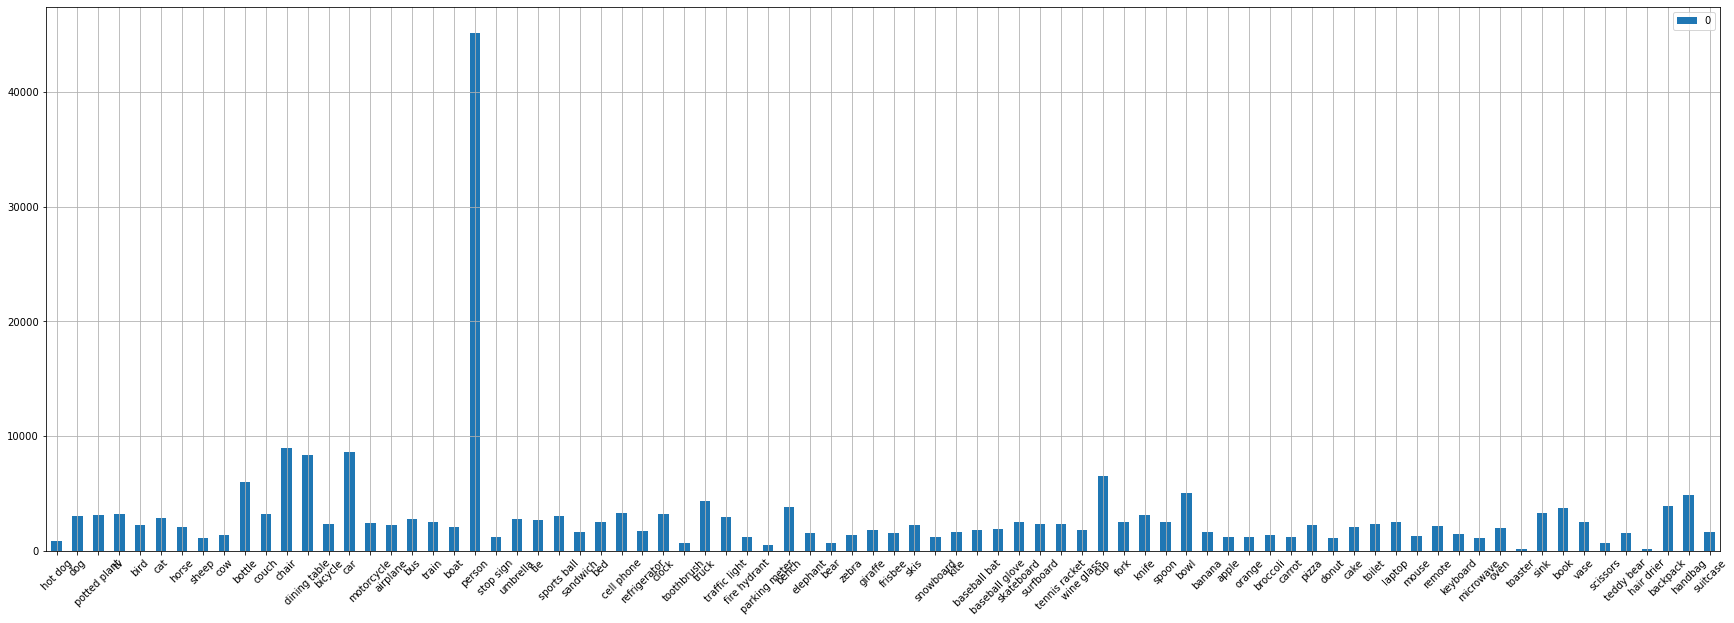

In [16]:
pd.DataFrame(pd.Series(to_plot)).plot(kind='bar', figsize=(30, 10), grid=True)
plt.xticks(rotation=45)
plt.show()

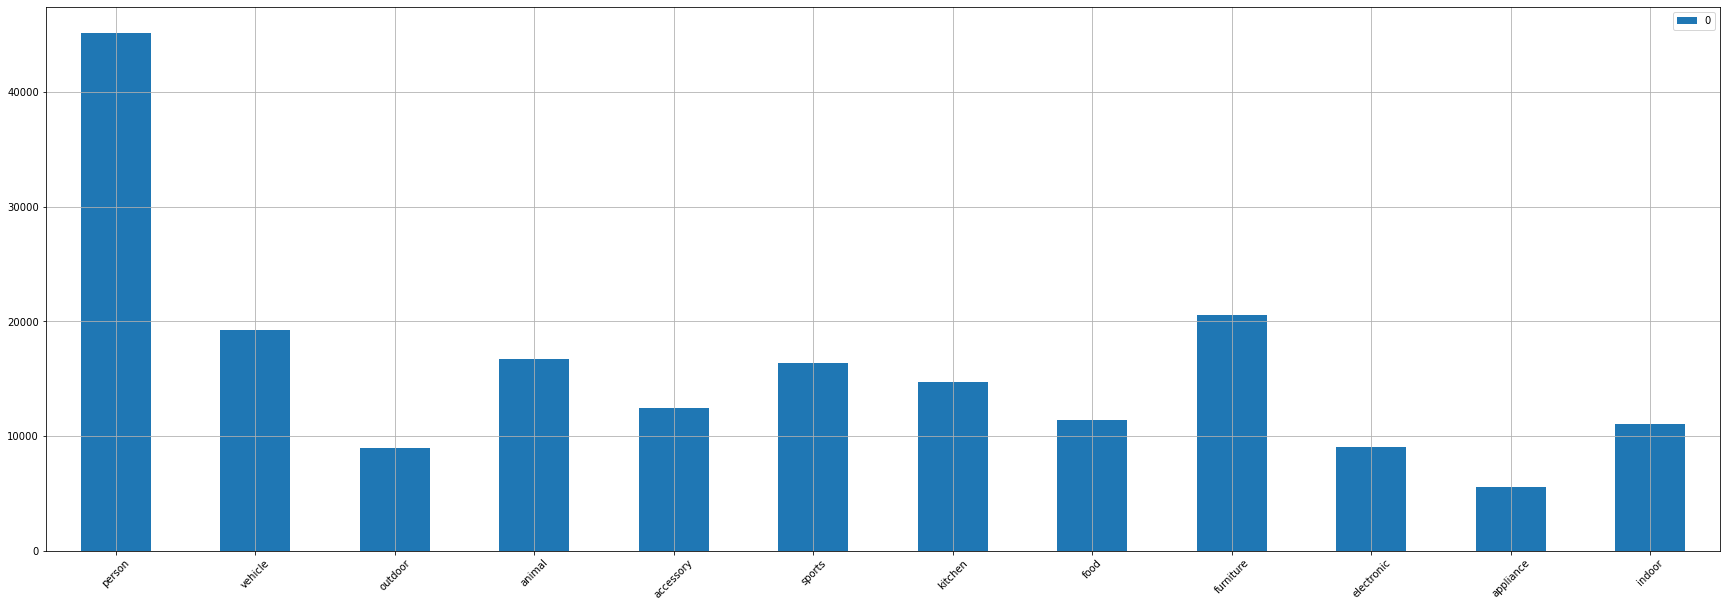

In [17]:
pd.DataFrame(pd.Series(count_imgs_by_supercat)).plot(kind='bar', figsize=(30, 10), grid=True)
plt.xticks(rotation=45)
plt.show()

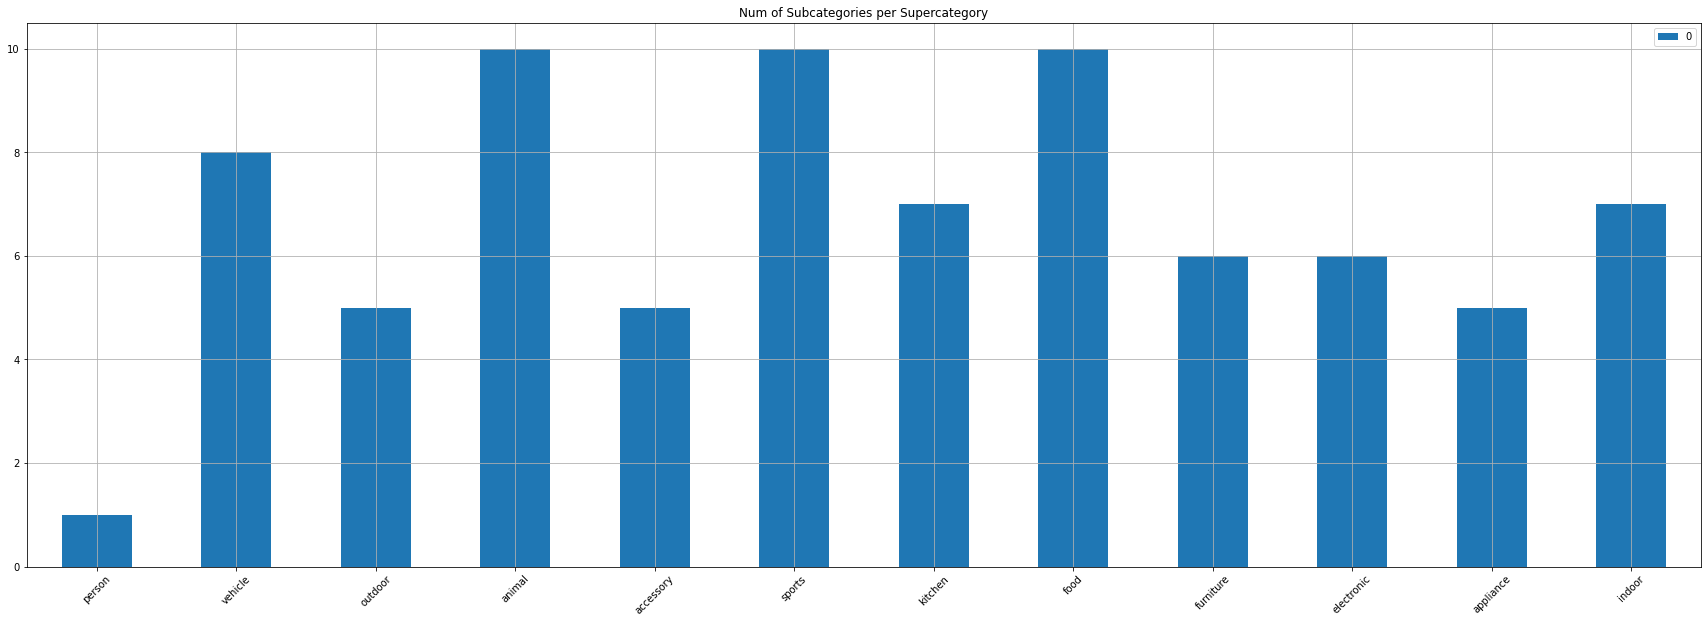

In [18]:
pd.DataFrame(pd.Series(num_subcats_by_supercat)).plot(kind='bar', figsize=(30, 10), grid=True)
plt.xticks(rotation=45)
plt.title('Num of Subcategories per Supercategory')
plt.show()

### Subset Image Ids
- get a unique list of image ids to use for training data
- get a unique list of image ids from validation data
- same for test data

- zip & upload to s3 for team use

In [19]:
desired_supercats = [
    'sports',
    'animal',
    'food'
]

In [20]:
# Get list of unique Image IDs for each of these subcategories
desired_imgs_by_supercat = {k: v for k, v in imgs_by_supercat.items() if k in desired_supercats}

In [21]:
for supercat, img_id in desired_imgs_by_supercat.items():
    print(supercat, len(img_id))

animal 16740
sports 16380
food 11415


In [22]:
# Subset to get the numpy filenames to re-zip
coco = coco_api_helper.coco_objects.get('train')

np_filenames = set()
np_filenames_by_supercat = defaultdict(list)
for supercat, img_ids in desired_imgs_by_supercat.items():
    for img_id in img_ids:
        np_filenames_by_supercat[supercat].append(coco.loadImgs([img_id])[0]['file_name'].rstrip('.jpg') + '.np')
        np_filenames.add(coco.loadImgs([img_id])[0]['file_name'].rstrip('.jpg') + '.np')
        
np_filenames = list(np_filenames)

In [92]:
train_subset_np_filepaths = [f"{train_subset_np_dir}{fn}" for fn in np_filenames]
len(train_subset_np_filepaths)

43266

In [95]:
train_np_data_dir

'../data/numpy_images/train/'

In [96]:
train_np_filepaths = [f"{train_np_data_dir}{fn}" for fn in np_filenames]

In [93]:
train_subset_np_filepaths[:3]

['../data/numpy_imgs/train_subset/COCO_train2014_000000183202.np',
 '../data/numpy_imgs/train_subset/COCO_train2014_000000440546.np',
 '../data/numpy_imgs/train_subset/COCO_train2014_000000081323.np']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


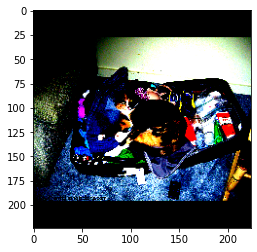

In [99]:
plt.imshow(np.load(train_subset_np_filepaths[0]))

In [100]:
np_filenames[0]

'COCO_train2014_000000183202.np'

In [101]:
train_subset_np_filepaths[0]

'../data/numpy_imgs/train_subset/COCO_train2014_000000183202.np'

In [97]:
for filepath, filename in tqdm(zip(train_np_filepaths, np_filenames)):
    image = np.load(filepath)
    
    if not os.path.exists(train_subset_np_dir):
        os.makedirs(train_subset_np_dir)
        
    with open(f"{train_subset_np_dir}{filename}", 'wb') as p:
        np.save(p, image, allow_pickle=True)

43266it [01:37, 445.69it/s]
